# v10 evaluation

In [1]:
import os
import sys
import random

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from torch.utils.data import DataLoader
from IPython.display import SVG, display

### 0. Add packages to python path

In [2]:
b_paths = [os.path.abspath(os.path.join('..', '..')), os.path.abspath(os.path.join('..')), os.path.abspath(os.path.join('..', 'scripts'))]
for b_path in b_paths:
    if b_path not in sys.path:
        sys.path.append(b_path)

BASE_DIR = Path(os.getcwd()).parent.parent.resolve()
%cd $BASE_DIR

/home/mirco/research/stroke2postfix-transformer


## 1. Load model and test set

In [3]:
from models.scripts.generate_arithmetic_sequences import SequenceGenerator
from models.scripts.transformer.ExprTree_model import load_json_hypeparameters, pad_collate_fn, model_builder
from models.scripts.transformer.utils import preprocess_dataset, seed_all, build_vocab, tensor_to_word, strokes_to_svg
from models.scripts.utils import Levenshtein_Normalized_distance

/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [4]:
VERSION = "v10"
SEED = 2021
BATCH_SIZE = 256
seed_all(SEED)

In [5]:
hp = load_json_hypeparameters(VERSION)
VOCAB = dict(hp['vocab'])
VOCAB = build_vocab(a for a in VOCAB.keys() if a not in ['<pad>', '<bos>', '<eos>', '<unk>'])
hp['vocab']=VOCAB
N_TOKENS = len(VOCAB)
PAD_IDX = VOCAB['<pad>']
BOS_IDX = VOCAB['<bos>']
EOS_IDX = VOCAB['<eos>']

print(f"Number of Tokens: {N_TOKENS}\n")
print({VOCAB.itos[i]: i for i in range(N_TOKENS)}) # Token order

Number of Tokens: 23

{'<unk>': 0, '<pad>': 1, '<bos>': 2, '<eos>': 3, '(': 4, ')': 5, '*': 6, '+': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, '=': 22}


In [6]:
d_gen = SequenceGenerator(
        vocab = VOCAB,
        allow_brackets = True,
        save_mode = 'marked_postfix',
        total_expressions = 120 * 1000)\

raw_test_set = d_gen.generate_from_cache(mode='test')

pre_test = preprocess_dataset(raw_test_set, VOCAB,  os.path.join(d_gen.fname, "test.pt"))

test_set = DataLoader(pre_test, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate_fn)

Using cached dataset file in cache/expressions_cache/expressions_120k_mb.h5
cache/preprocessed_datasets/expressions_120k_mb/test.pt
Using cached processed dataset


In [9]:
model = model_builder(name=VERSION, **hp)
model.load_best_version()

## 2. Test on a single expression (0 and 1 required)

In [10]:
test_set_iter = iter(test_set)
x_pred, y_pred = next(test_set_iter)

x_pred = x_pred.to(model.device)
y_pred = y_pred.to(model.device)

Index: 126 



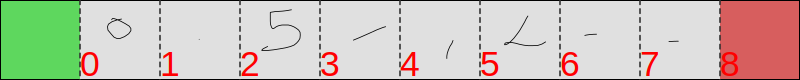

Ground truth =>  [2, 12, 10, 17, 8, 16, 8, 9, 22, 3] 

Ground Truth: <bos>0.5,4,-=<eos><pad><pad><pad><pad><pad><pad><pad> (len=8)
- Prediction: 0.5,4,-=<eos> (len=7)
Normalized Levenshtein distance is: 0.0


In [15]:
ind = random.choice(range(0, y_pred.shape[0]))
print("Index:", ind, "\n")

svg_str = strokes_to_svg(x_pred[ind], {'height':100, 'width':100}, d_gen.padding_value, BOS_IDX, EOS_IDX)
display(SVG(data = svg_str))

gt = tensor_to_word(y_pred[ind], VOCAB)
gt_list = [i for i in y_pred[ind].tolist() if i != 1]
gt_length = len([i for i in y_pred[ind] if i not in [PAD_IDX, BOS_IDX, EOS_IDX]])
prediction, _ = model.predict(x_pred[ind].unsqueeze(0))

print("Ground truth => ", gt_list , '\n')

# Show ground truth and prediction along with the lengths of the words/glyphs
print(f"Ground Truth: {''.join(gt)} (len={gt_length})")
print(f"- Prediction: {''.join(prediction)} (len={len(prediction)-2})")

print(f"Normalized Levenshtein distance is: {Levenshtein_Normalized_distance(a=''.join(gt).strip('<bos>').strip('<pad>').strip('<eos>'), b=''.join(prediction).strip('<bos>').strip('<eos>').strip('<pad>'))}")

In [ ]:
model.trace_and_export(src=x_pred[ind].unsqueeze(0), trg=y_pred[ind].unsqueeze(0), version=f"{VERSION}_single_test")

## 3. Evaluate on test set (0 and 1 required)

### Compute average test set cross-entropy loss (XEL)

In [ ]:
test_loss = model.evaluate_f(test_set)

print(f'Test Loss: {test_loss:.3f}')

Test Loss: 0.340


In [ ]:
test_set_iter = iter(test_set)
avg_lev_acc = model.evaluate_Levenshtein_accuracy(test_set_iter)
print(f"\nNormalized Levenshtein accuracy of test set is: {avg_lev_acc}")

 99%|█████████▉| 187/188 [44:20<00:14, 14.23s/it]


Normalized Levenshtein accuracy of test set is: 0.8737767791236738


### Compute character error rate

In [ ]:
test_set_iter = iter(test_set)
avg_cer = model.evaluate_CER(test_set_iter)
print(f"\nCharacter Error Rate of test set is: {avg_cer}")

 99%|█████████▉| 187/188 [42:08<00:13, 13.52s/it]


Character Error Rate of test set is: 0.14143051207065582


In [ ]:
### ATTENTION #### it would need to load in memory the whole test set!!!!

model.trace_and_export(src=test_set, trg=test_set, version=f"{VERSION}_test_set")

## 4. Visualization (0,1,2 required)
### Cross-attention visualization

Index: 126
Ground truth =>  [2, 12, 10, 17, 8, 16, 8, 9, 22, 3] 

Ground Truth: <bos>0.5,4,-=<eos><pad><pad><pad><pad><pad><pad><pad> (len=8)
- Prediction: 0.5,4,-=<eos> (len=7)
X axis =>  ['<', 'b', 'o', 's', '>', '0', '.', '5', ',', '4', ',', '-', '=', '<', 'e', 'o', 's', '>', '<', 'p', 'a', 'd', '>', '<', 'p', 'a', 'd', '>', '<', 'p', 'a', 'd', '>', '<', 'p', 'a', 'd', '>', '<', 'p', 'a', 'd', '>', '<', 'p', 'a', 'd', '>', '<', 'p', 'a', 'd', '>']
Y axis =>  ['0', '.', '5', ',', '4', ',', '-', '=', '<eos>']


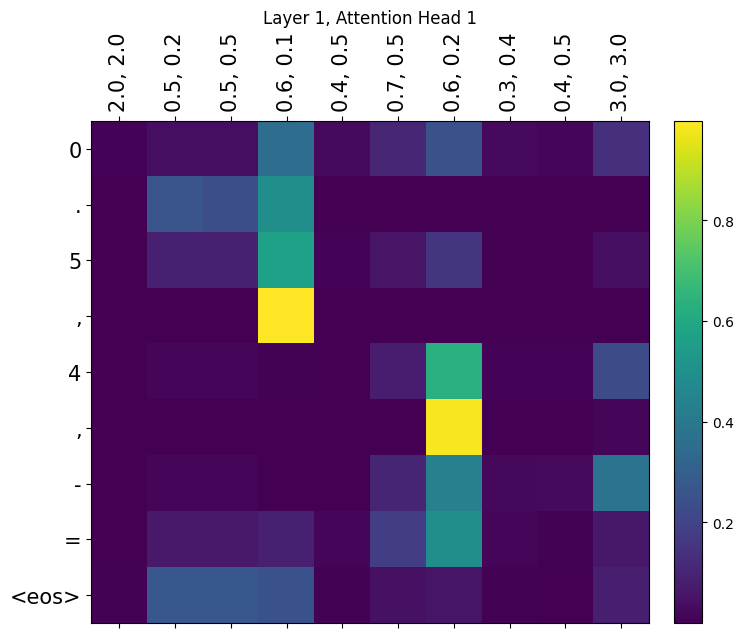

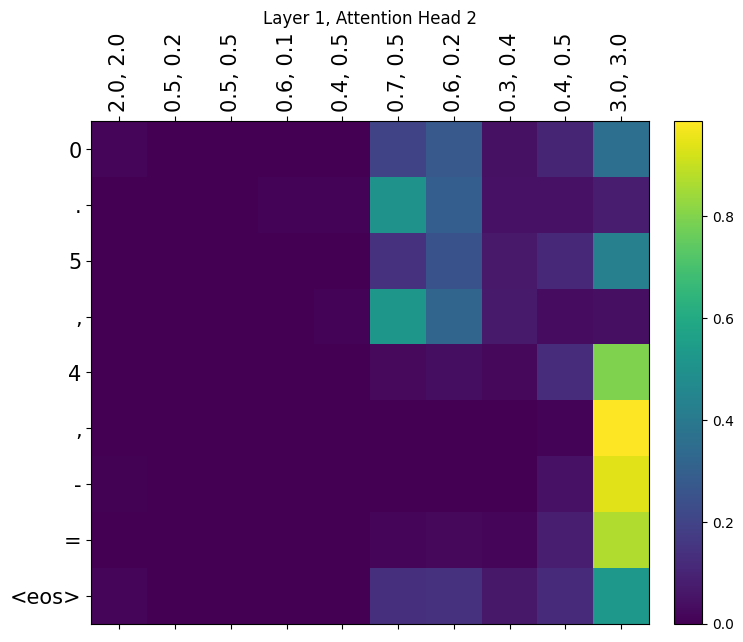

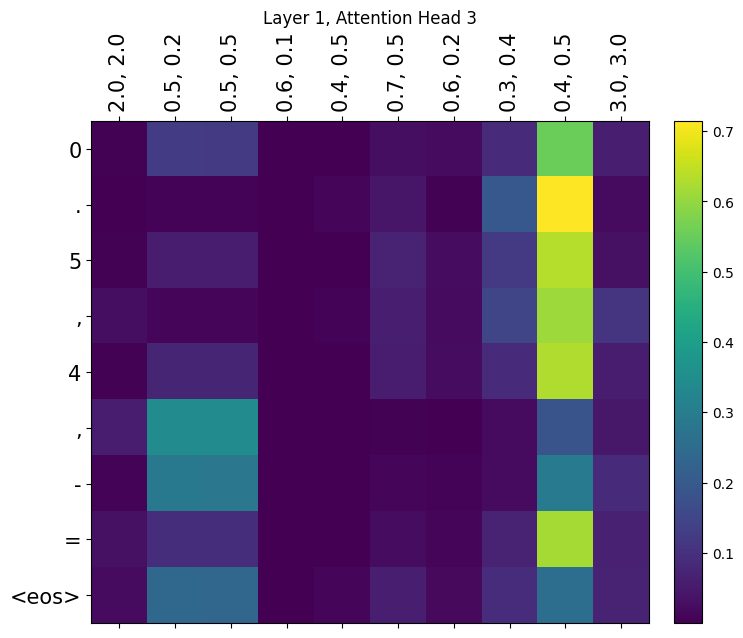

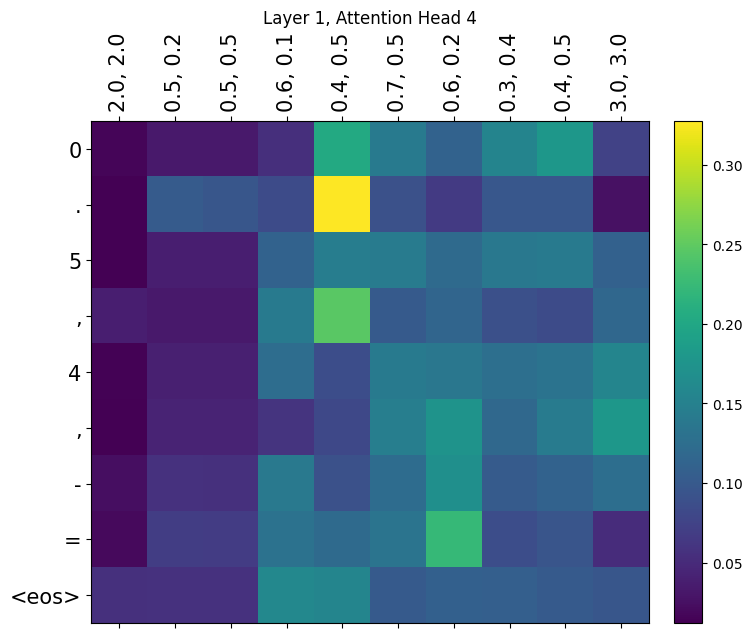

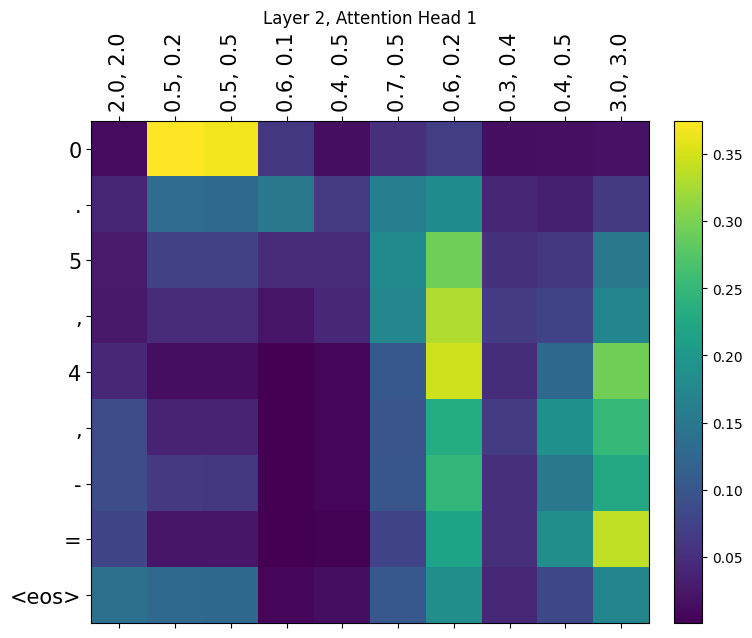

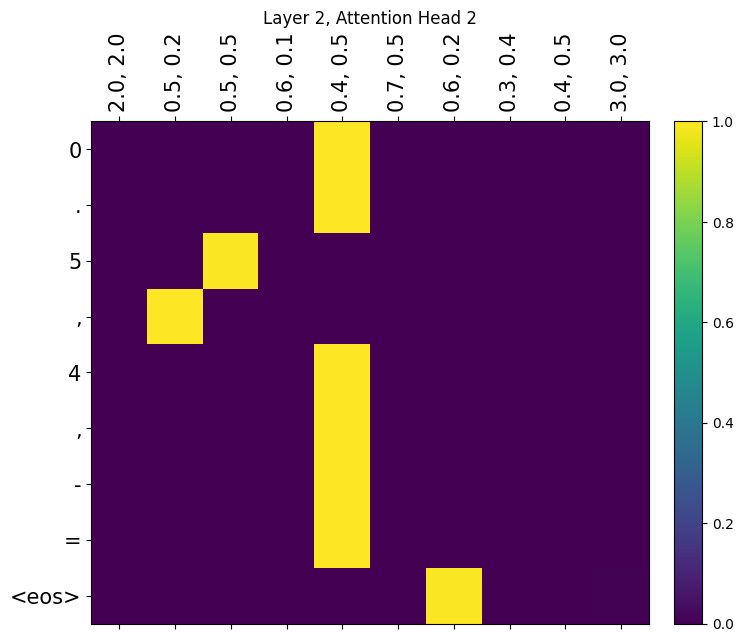

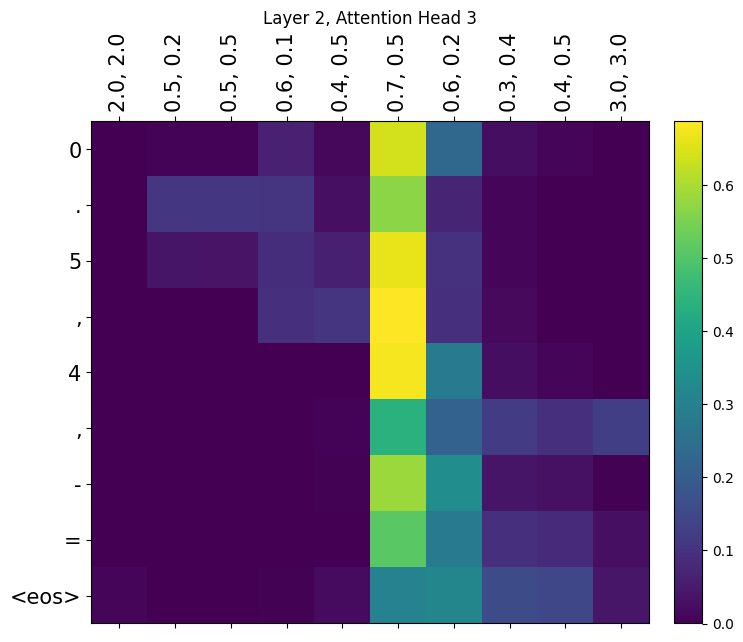

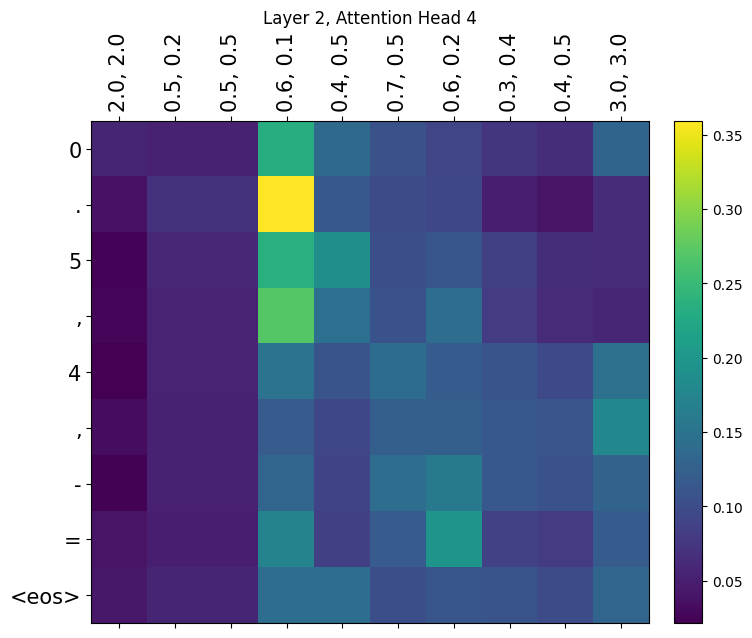

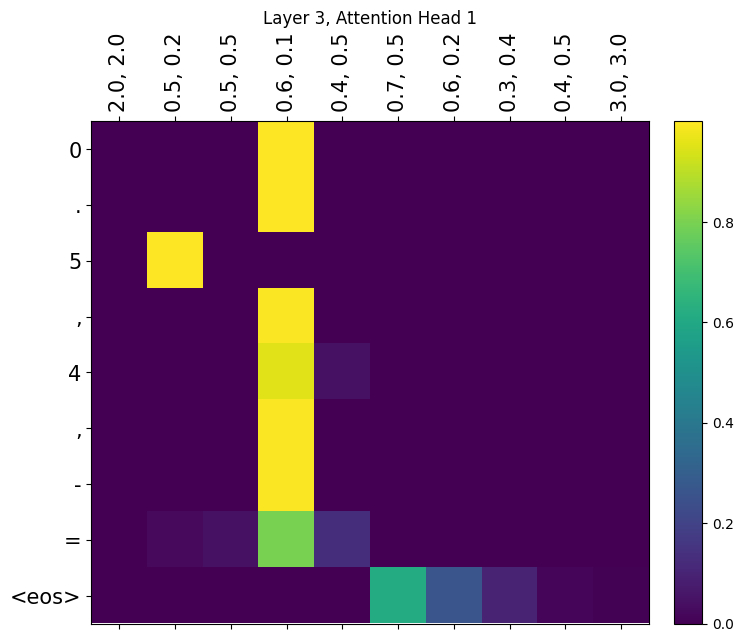

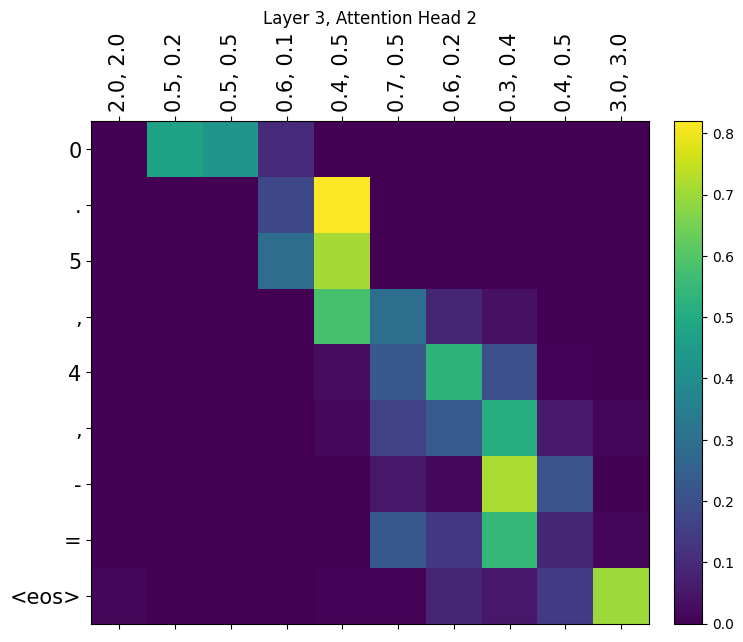

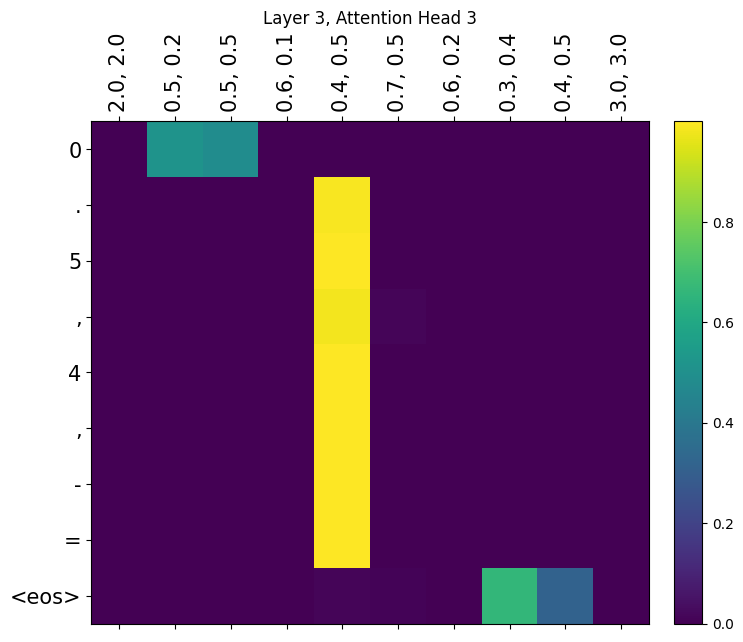

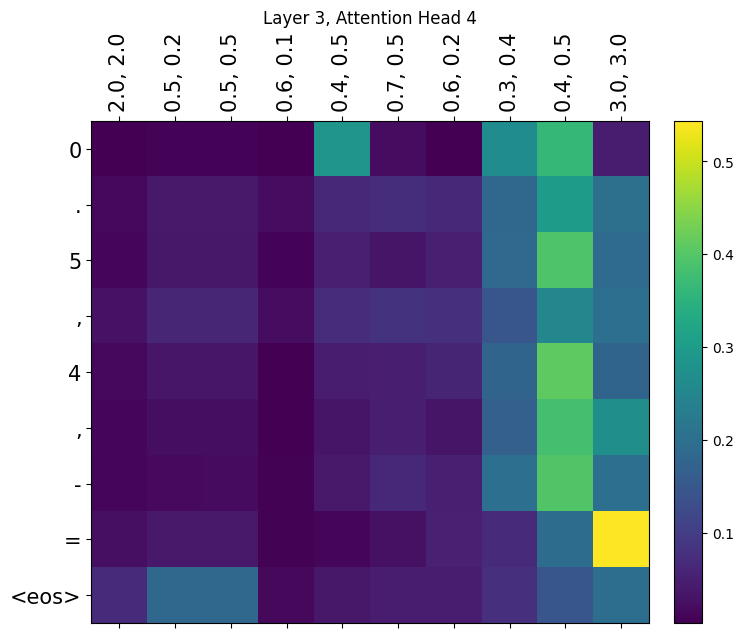

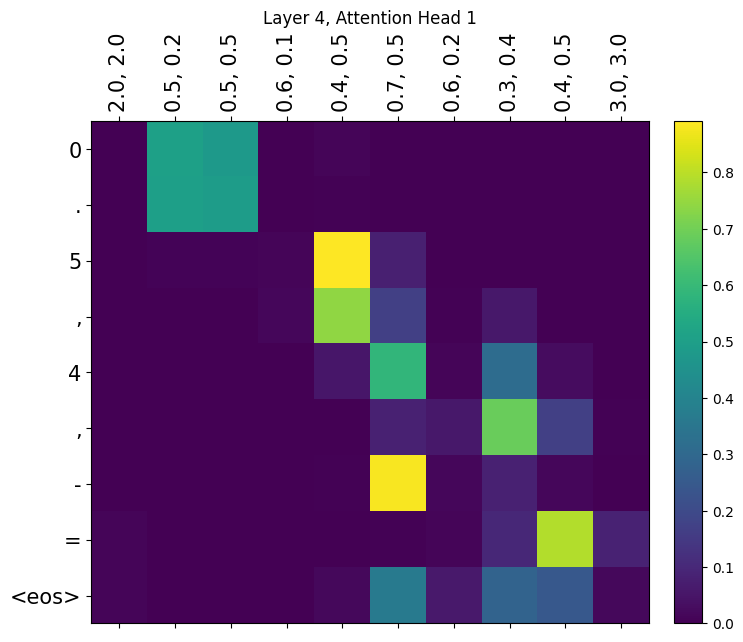

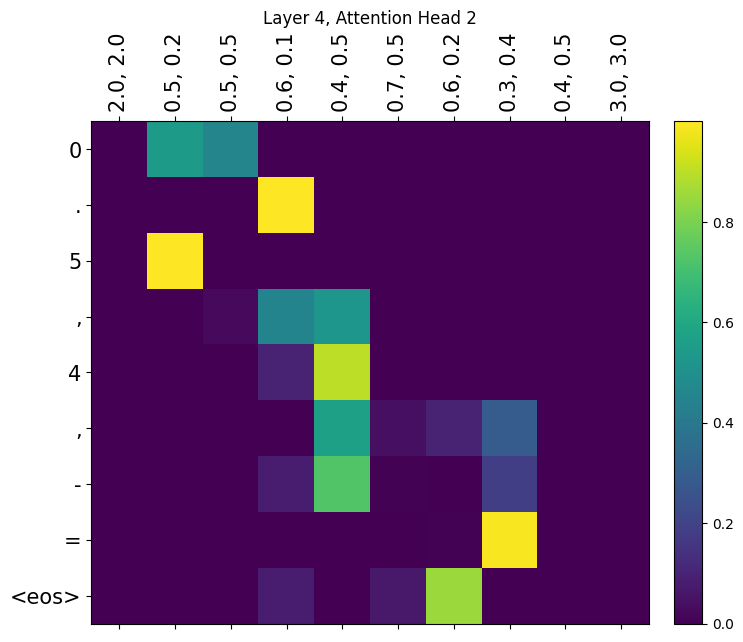

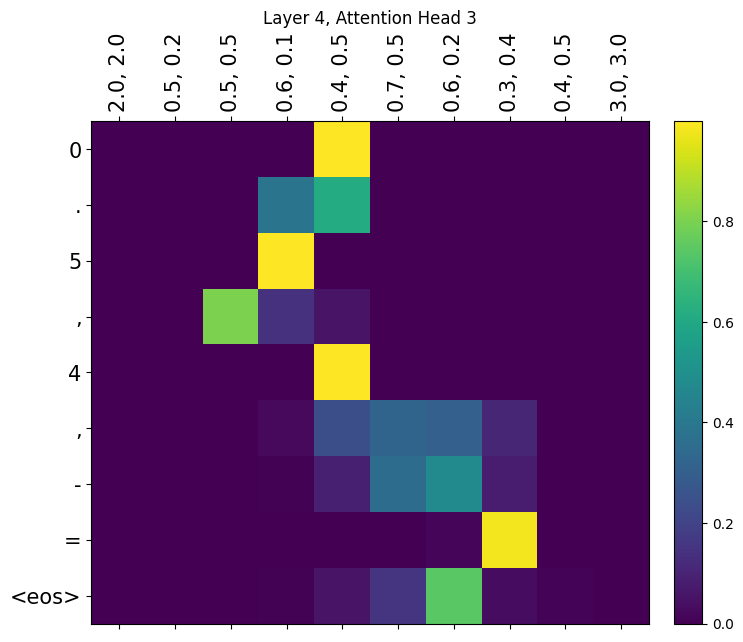

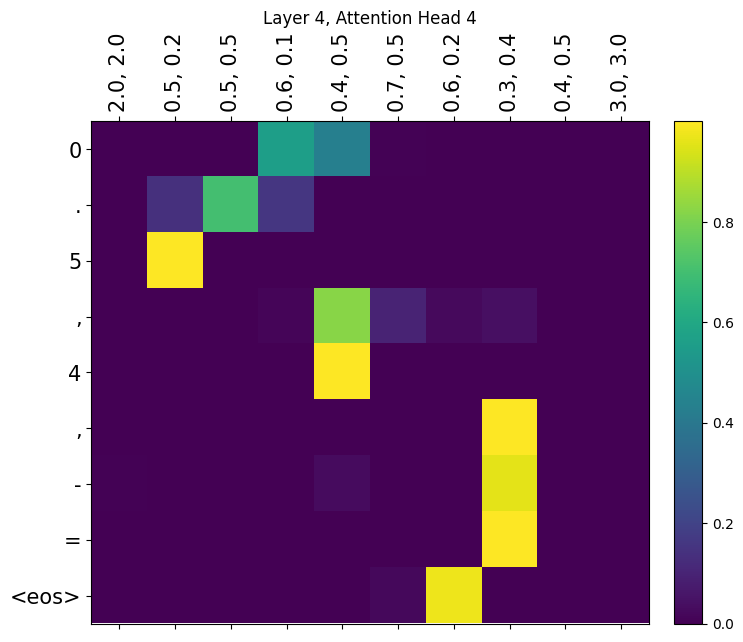

In [16]:
print("Index:", ind)

gt = tensor_to_word(y_pred[ind], VOCAB)
gt_list = [i for i in y_pred[ind].tolist() if i != 1]
gt_length = len([i for i in y_pred[ind] if i not in [PAD_IDX, BOS_IDX, EOS_IDX]])
prediction, attention = model.predict(x_pred[ind].unsqueeze(0))

print("Ground truth => ", gt_list , '\n')

# Show ground truth and prediction along with the lengths of the words/glyphs
print(f"Ground Truth: {''.join(gt)} (len={gt_length})")
print(f"- Prediction: {''.join(prediction)} (len={len(prediction)-2})")

end_index = d_gen.n_features
gt_expr = [", ".join(f"{j:.1f}" for j in i[0: end_index]) for i in x_pred[ind].tolist()]
translation = [i for i in prediction]

print("X axis => ", [i for i in gt])
print("Y axis => ", translation)

model.display_attention(gt_expr, translation, attention[0]) #cross-attention

In [ ]:
test_set_iter = iter(test_set)
avg_postfix_acc = model.evaluate_postfix_accuracy(test_set_iter, separator=True)
print(f"\nMin and max accuracy of test set are: {avg_postfix_acc}")

 99%|█████████▉| 187/188 [36:09<00:11, 11.60s/it]


Min and max accuracy of test set are: (0.9239695040214475, 0.9315934986595175)


## Ablation studies

### Removing equal sign's glyphs

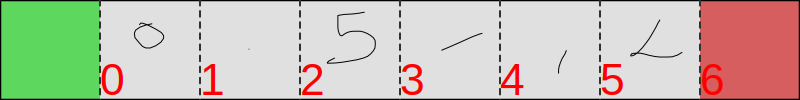

Ground truth =>  [2, 12, 10, 17, 8, 16, 8, 9, 22, 3, 1, 1, 1, 1, 1, 1, 1] 

Ground Truth: <bos>0.5,4,-=<eos><pad><pad><pad><pad><pad><pad><pad> (len=7)
- Prediction: 0.5,4,-=<eos> (len=7)
Normalized Levenshtein distance is: 0.125


In [17]:
from models.scripts.transformer.utils import remove_equal_sign

new_tensor = remove_equal_sign(x_pred[ind])

svg_str = strokes_to_svg(new_tensor, {'height':100, 'width':100}, d_gen.padding_value, BOS_IDX, EOS_IDX)
display(SVG(data = svg_str))

gt = tensor_to_word(y_pred[ind], VOCAB)
gt_list = [i for i in y_pred[ind].tolist() if i != 1 or i != VOCAB.stoi['=']]
gt_length = len([i for i in y_pred[ind] if i not in [PAD_IDX, BOS_IDX, EOS_IDX]])-1
prediction, attention = model.predict(new_tensor.unsqueeze(0))

print("Ground truth => ", gt_list , '\n')

# Show ground truth and prediction along with the lengths of the words/glyphs
print(f"Ground Truth: {''.join(gt)} (len={gt_length})")
print(f"- Prediction: {''.join(prediction)} (len={len(prediction)-2})")

print(f"Normalized Levenshtein distance is: {Levenshtein_Normalized_distance(a=''.join(gt).strip('<bos>').strip('<pad>').strip('<eos>').strip('='), b=''.join(prediction).strip('<bos>').strip('<eos>').strip('<pad>'))}")

### Removing last operator

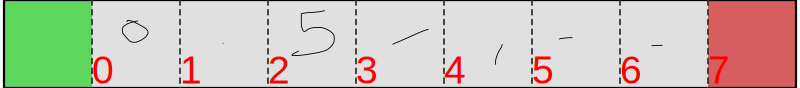

Ground truth =>  [2, 12, 10, 17, 8, 16, 8, 9, 22, 3, 1, 1, 1, 1, 1, 1, 1] 

Ground Truth: <bos>0.5,4,-=<eos><pad><pad><pad><pad><pad><pad><pad> (len=7)
- Prediction: 0.5,1,-=<eos> (len=7)
Normalized Levenshtein distance is: 0.23529411764705882


In [18]:
from models.scripts.transformer.utils import remove_last_operator

new_tensor = remove_last_operator(x_pred[ind])

svg_str = strokes_to_svg(new_tensor, {'height': 100, 'width': 100}, d_gen.padding_value, BOS_IDX, EOS_IDX)
display(SVG(data=svg_str))

gt = tensor_to_word(y_pred[ind], VOCAB)
gt_list = [i for i in y_pred[ind].tolist() if i != 1 or i != VOCAB.stoi['=']]
gt_length = len([i for i in y_pred[ind] if i not in [PAD_IDX, BOS_IDX, EOS_IDX]]) - 1
prediction, _ = model.predict(new_tensor.unsqueeze(0))

print("Ground truth => ", gt_list, '\n')

# Show ground truth and prediction along with the lengths of the words/glyphs
print(f"Ground Truth: {''.join(gt)} (len={gt_length})")
print(f"- Prediction: {''.join(prediction)} (len={len(prediction) - 2})")

print(
    f"Normalized Levenshtein distance is: {Levenshtein_Normalized_distance(a=''.join(gt).strip('<bos>').strip('<pad>').strip('<eos>').strip('='), b=''.join(prediction).strip('<bos>').strip('<eos>').strip('<pad>'))}")

## Visualize softmax probabilities

Index: 17 



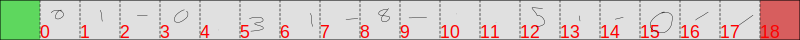

Ground truth =>  [2, 12, 8, 12, 10, 15, 8, 7, 20, 8, 17, 8, 11, 7, 12, 8, 3] 

Ground Truth: <bos>0,0.3,+8,5,/+0,<eos> (len=15)
- Prediction: 0,6.3,+8,5,/+0,<eos> (len=14)
Normalized Levenshtein distance is: 0.06451612903225806


In [19]:
ind = random.choice(range(0, y_pred.shape[0]))
print("Index:", ind, "\n")

svg_str = strokes_to_svg(x_pred[ind], {'height':100, 'width':100}, d_gen.padding_value, BOS_IDX, EOS_IDX)
display(SVG(data = svg_str))

gt = tensor_to_word(y_pred[ind], VOCAB)
gt_list = [i for i in y_pred[ind].tolist() if i != 1]
gt_length = len([i for i in y_pred[ind] if i not in [PAD_IDX, BOS_IDX, EOS_IDX]])
prediction, _, probabilities = model.predict_with_probabilities(x_pred[ind].unsqueeze(0))

print("Ground truth => ", gt_list , '\n')

# Show ground truth and prediction along with the lengths of the words/glyphs
print(f"Ground Truth: {''.join(gt)} (len={gt_length})")
print(f"- Prediction: {''.join(prediction)} (len={len(prediction)-2})")

print(f"Normalized Levenshtein distance is: {Levenshtein_Normalized_distance(a=''.join(gt).strip('<bos>').strip('<pad>').strip('<eos>'), b=''.join(prediction).strip('<bos>').strip('<eos>').strip('<pad>'))}")

torch.Size([16, 23])


<AxesSubplot: >

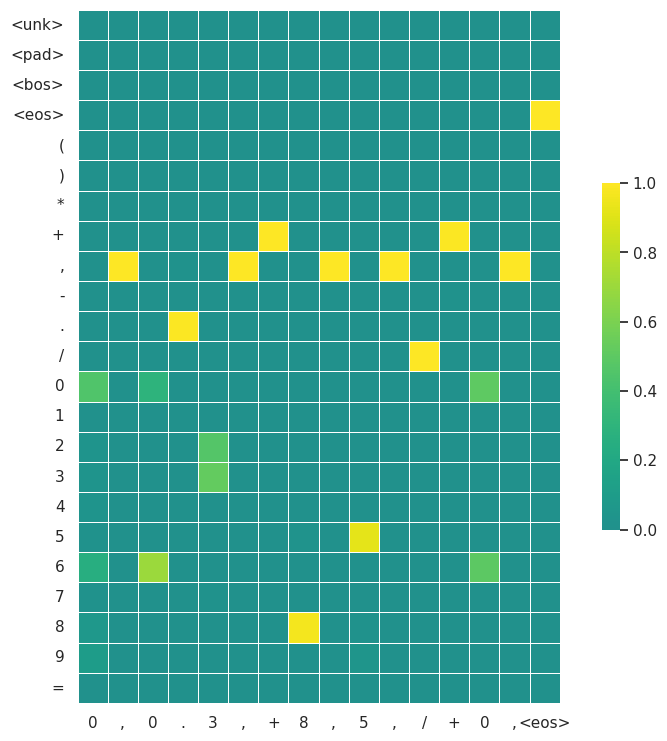

In [20]:
sns.set_theme(style="white")

probabilities = probabilities[probabilities.sum(dim=1)>0]
print(probabilities.shape)

# Generate a large random dataset
d = pd.DataFrame(data=np.array(probabilities).transpose(),
                 columns=[VOCAB.itos[v] for v in gt_list[1:]])


d.index = VOCAB.itos

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette("viridis", as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(d, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5 , cbar_kws={"shrink": .5})

### Show average glyph confidence

In [21]:
test_set_iter = iter(test_set)
avg_probs = model.compute_glyph_average_probabilities(test_set_iter)

  0%|          | 0/188 [00:00<?, ?it/s]/home/mirco/research/stroke2postfix-transformer/models/scripts/transformer/ExprTree_model.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yy.append(torch.tensor(y_, dtype=torch.int64))
100%|██████████| 188/188 [35:40<00:00, 11.39s/it]


<AxesSubplot: >

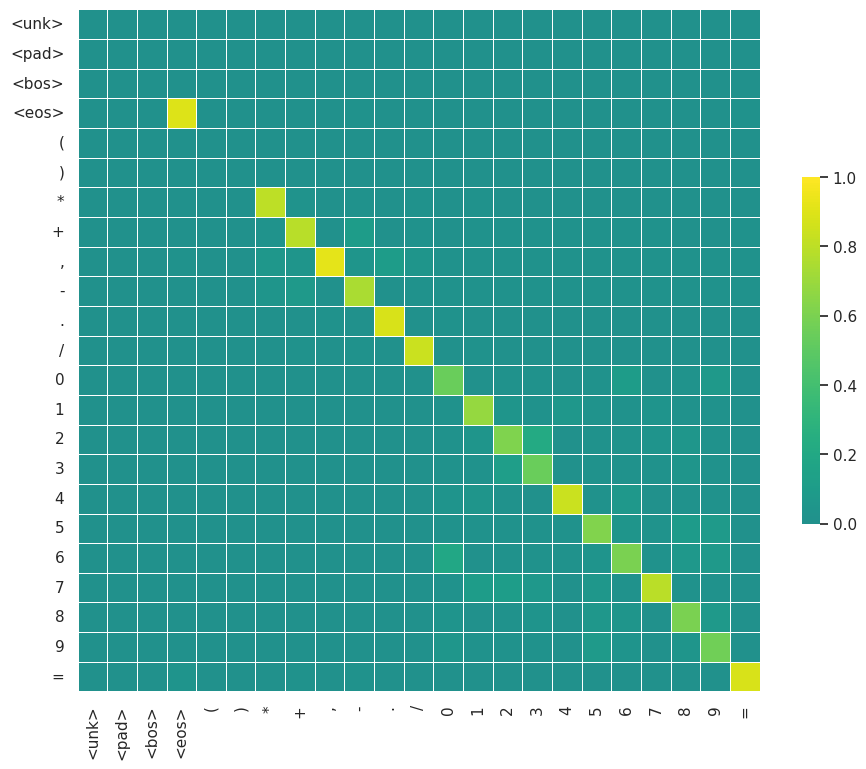

In [23]:
sns.set_theme(style="white")

# Generate a large random dataset
d = pd.DataFrame(data=avg_probs.transpose(),
                 columns=VOCAB.itos)


d.index = VOCAB.itos

# Set up the matplotlib figure
_, _ = plt.subplots(figsize=(11, 9))

#viridis palette
cmap = sns.color_palette("viridis", as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(d, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5 , cbar_kws={"shrink": .5})